In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

- torchvision에서 가져오는 데이터는 10개의 사물 분류 이미지
    - Cifar-10 데이터
        - 6만장
        - RGB
        - 높이, 너비는 각각 32
        - 비행기, 자동차, ...

In [4]:
torch.manual_seed(50)
train_dataset = datasets.CIFAR10('./dataset', train=True, download=True, 
                transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10('./dataset', train=False,
                transform = transforms.ToTensor())

170500096it [18:50, 231186.46it/s]                                                                                     

In [5]:
len( train_dataset ), len( test_dataset ), type( train_dataset )

(50000, 10000, torchvision.datasets.cifar.CIFAR10)

In [6]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
print( train_dataset.classes )

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
# 랜덤 이미지
idx = torch.randint( 0, len(train_dataset), (1,) ).item()
idx

47904

In [9]:
random_image = train_dataset[idx][0]
random_image.shape

torch.Size([3, 32, 32])

In [10]:
# 클래스 분류값
train_dataset[idx][1]

2

In [11]:
train_dataset.classes[ train_dataset[idx][1] ]

'bird'

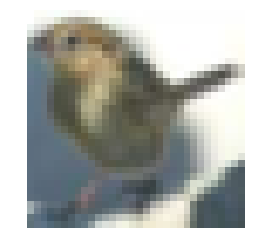

In [12]:
# 데이터의 차원 이동을 하여 그릴 수 있게 조정
plt.imshow( random_image.numpy().transpose(1, 2, 0) )
plt.axis('off')
plt.show()

In [13]:
# 환경변수, 학습용 상수
BATCH = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
STEP = 30
PRINT_STEP = 180

BATCH, DEVICE, STEP, PRINT_STEP

(128, 'cpu', 30, 180)

In [14]:
train_loader = DataLoader( train_dataset, batch_size= BATCH, shuffle= True )
train_loader

In [15]:
test_loader = DataLoader( test_dataset, batch_size= BATCH, shuffle= True )
test_loader

In [16]:
len(train_loader), len(test_loader)

(391, 79)

- CNN 클래스 생성
    - 합성곱 형태 정의
        - case1) 합성곱층 : nn.Conv2d + nn.ReLU, 풀링층 : nn.MaxPool2d
        - case2) 합성곱층 : nn.Conv2d + nn.ReLU, nn.MaxPool2d

<tr>
    <td><img src = './data/8.cnn_value.jpeg'></td>
    <td><img src = './data/6.cnn_shape.jpeg'></td>
</tr>

- W(or H) = (W(in) + 2*P - K)/S + 1를 이용하여 레이어를 통과할 때 크기를 계산
- features의 수는 채널 수 * 이미지 세로 * 이미지 가로

- nn.Module
    - 신경망 모듈의 기본 클래스
    - 모든 모델은 이 클래스를 상속받아야 한다

In [23]:
class CNN(nn.Module) :
    
    # 생성자
    def __init__(self) :
        # 부모 생성자 호출
        super(CNN, self).__init__()
        
        # 합성곱층 생성
        self.conv1 = nn.Conv2d( 
                        in_channels = 3,
                        out_channels = 8,
                        kernel_size = 5,
                        stride = 1,
                        padding = 1
                    )
        self.conv2 = nn.Conv2d( 
                        in_channels = 8,
                        out_channels = 16,
                        kernel_size = 2,
                        stride = 1,
                        padding = 0
                    ) 
        
        # 렐루 생성
        self.relu = nn.ReLU(inplace = True)
        
        # 풀링 생성
        self.pool = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        # 전결합층 생성
        # (128, 16, 7, 7) → (128, 16*7*7) = (128, 784)
        # (batch, 16, 7, 7) → (batch, 16*7*7) = (batch, 784)
        # reshape = view
        # x.view( batch 크기, "나머지는 2차원에 맞게 알아서 펴라" )
        self.flatten = lambda x : x.view( x.size(0) , -1 )
        self.fc = nn.Linear( 784, 10 )
        
    '''
    - 모든 호출에서 사용하는 연산 정의
    - 모든 서브클래스(CNN)은 이 함수를 반드시 재정의해야 한다
    - 층을 정의한다(레이어 정의)
    - x : 입력 텐서, 입력 데이터
    '''
    
    def forward(self, x) :
        # 합성곱층의 체이닝
        # 컨볼루젼1
        x = self.conv1(x)
        # 렐루
        x = self.relu(x)
        # 풀링
        x = self.pool(x)
        # 컨볼루젼2
        x = self.conv2(x)
        # 렐루
        x = self.relu(x)
        # 풀링
        x = self.pool(x)
        # 전결합층
        x = self.flatten(x)
        x = self.fc(x)
        # 출력계층은 작업 후 처리로 설정
        
        return x

In [24]:
# 모델 선언
model = CNN().to(DEVICE)

In [25]:
# 손실함수, 크로스엔트로피
loss_func = nn.CrossEntropyLoss()

In [26]:
# 옵티마이저, 확률적 경사 하강법
optimizer = optim.Adam( model.parameters() )

In [27]:
from train_utils_mod import main

In [28]:
# 훈련 및 테스트
main(
    model        = model,                  # nn.model을 상속받은 클래스
    train_loader = train_loader,           # 훈련 데이터
    test_loader  = test_loader,            # 테스트 데이터
    loss_func    = loss_func,              # 손실함수
    optimizer    = optimizer,              # 최적화도구
    n_step       = STEP,                   # 반복 스텝, 학습의 양
    device       = DEVICE,                 # cpu, cuda
    save_path    = 'cifar10_model_v1.pt',  # 학습 완료한 모델의 덤프
    print_step   = PRINT_STEP     # 수행 시 얼마 간격으로 진행 상황을 출력할 것인가
)

Train Step: 1 (00.00%)  	Loss: 2.3098
Train Step: 1 (46.08%)  	Loss: 1.7915
Train Step: 1 (92.16%)  	Loss: 1.6922
Test set: Average loss: 1.6197, Accuracy: 4248/10000 (42.48%)

Train Step: 2 (00.00%)  	Loss: 1.5471
Train Step: 2 (46.08%)  	Loss: 1.4780
Train Step: 2 (92.16%)  	Loss: 1.5369
Test set: Average loss: 1.5089, Accuracy: 4629/10000 (46.29%)
discard previous state, best model state saved!

Train Step: 3 (00.00%)  	Loss: 1.6616
Train Step: 3 (46.08%)  	Loss: 1.4915
Train Step: 3 (92.16%)  	Loss: 1.3227
Test set: Average loss: 1.4510, Accuracy: 4776/10000 (47.76%)
discard previous state, best model state saved!

Train Step: 4 (00.00%)  	Loss: 1.6230
Train Step: 4 (46.08%)  	Loss: 1.3998
Train Step: 4 (92.16%)  	Loss: 1.3969
Test set: Average loss: 1.3517, Accuracy: 5236/10000 (52.36%)
discard previous state, best model state saved!

Train Step: 5 (00.00%)  	Loss: 1.3973
Train Step: 5 (46.08%)  	Loss: 1.3041
Train Step: 5 (92.16%)  	Loss: 1.3450
Test set: Average loss: 1.3098, Ac

- 정확도가 낮다
    - 더 큰 모델(이미지)을 이용하여 학습
    - 데이터를 더 늘려서 학습
    - 배치 정규화를 통해서 학습 성능을 향상 (채널 수, 스트라이드, 패딩, 커널사이즈 등)
    - 알고리즘을 추가하여 개선하는 방법

In [30]:
config = [ ('ch_in', 3),
           ('n_in', 32),  # 이미지의 사이즈(height or weight, 동일)
           ('conv1', (32, 7, 1, 1)), ('pool1', 2),
           ('conv2', (64, 5, 1, 0)), ('pool2', 2),
           ('conv3', (128, 3, 1, 0)), ('pool3', 2),
           ('fc', (250, 50, 10))
         ]
dict(config)

{'ch_in': 3,
 'n_in': 32,
 'conv1': (32, 7, 1, 1),
 'pool1': 2,
 'conv2': (64, 5, 1, 0),
 'pool2': 2,
 'conv3': (128, 3, 1, 0),
 'pool3': 2,
 'fc': (250, 50, 10)}

In [42]:
for (k, v) in config :
    if 'conv' in k :
        print(k, v)
    elif 'pool' in k :
        print(k, v)

conv1 (32, 7, 1, 1)
pool1 2
conv2 (64, 5, 1, 0)
pool2 2
conv3 (128, 3, 1, 0)
pool3 2


In [31]:
# 특정 항목의 값
dict(config)['ch_in']

3

In [38]:
# 컨볼루젼 계층의 총 개수
# for k in dict(config) :
#     if 'conv' in k :
#         print(k)
sum([ True for k in dict(config) if 'conv' in k ])

3

In [43]:
a = [1]
a += [2, 3, 4]
a

[1, 2, 3, 4]

In [39]:
class CNNEx(nn.Module) :
    
    def __init__(self, config) :
        super(CNNEx, self).__init__()
        # 컨볼루젼 계층(conv, pool) 병행
        self.convs = nn.Sequential(*self._make_layers(config) )
        # 전결합층
        # 전결합층 - flatten
        self.flatten = lambda x : x.view( x.size(0), -1 )
        # 전결합층 - 실제
        self.fc = nn.Sequential(*self._make_layers(config, name = 'fc') )
    
    # 계층 연결
    def forward(self, x) :
        x = self.convs(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
    # config의 구성에 맞춰서 name에 해당되는 계층을 자동 생성한다
    def _make_layers(self, config, name = 'convs') :
        
        # [ 합, 배치정규, 렐루, 풀, 합, 배치정규, 렐루, 풀, 합, 배치정규, 렐루, 풀, ... ]
        layers = []
        ch_in = dict(config)['ch_in']
        
        if name == 'convs' :  # 합성곱층을 config에 설정된 값에 따라 완성한다
            for (k, v) in config :
                if 'conv' in k :  # 합성곱층
                    # print(k, v)
                    # (32, 7, 1, 1) : (출력 채널, 커널 크기, 스트라이드, 패딩)
                    ch_out, k, s, p = v
                    
                    # 레이어 생성
                    layers += [ 
                        nn.Conv2d(
                                in_channels = ch_in,      # 입력채널
                                out_channels = ch_out,    # 출력채널
                                kernel_size = k,          # 커널 사이즈
                                stride = s,               # 스프라이드 사이즈
                                padding = p               # 패딩 사이즈
                        ),
                        # 학습능력을 향상시키기 위해 배치 정규화 추가
                        nn.BatchNorm2d(ch_out),
                        nn.ReLU(inplace = True)
                        ]
                    # 현재 완료된 layer의 출력 채널 수를
                    # 다음 번 layer의 입력 채널 수로 설정
                    ch_in = ch_out
                
                elif 'pool' in k :  # 풀링층
                    # print(k, v)
                    layers += [ 
                        # 통상 커널사이즈와 동일하게 스트라이드 값을 부여
                        # 만약 다르게 하고 싶으면 ('pool1', (2, 4)) 값을 추가 → 수정
                        nn.MaxPool2d(kernel_size=v, stride = v)
                    ]
        elif name = 'fc' :
            pass
        
        else :
            print('잘못 입력했습니다.')
        
        return layers
    
    
    # fc의 입력 채널 수 계산
    def _get_fc_input(self, config) :
        config = dict( config )
        n_in = config[n_in]  # 이미지의 사이즈(세로 혹은 가로) # 32
        # 컨볼루젼의 계층이 몇 번 존재하는가?
        convs_cnt = sum([ True for k in dict(config) if 'conv' in k ]) # 3
        # conv1, conv2, conv3 → 1 ~ 3
        for i in range(1, convs_cnt+1) :
            ch_out, k, s, p = config['conv%s' % i ]
            pool_k = config['pool%s' % i ]
            # 컨볼루전 통과 후 사이즈
            conv_n = 